In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def f(x):
    return 3*x**2 - 4*x + 5

In [21]:
f(3.0)

20.0

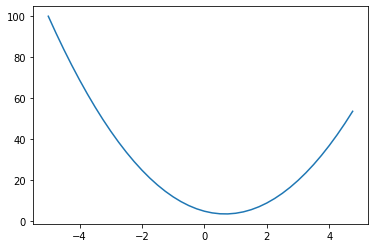

In [22]:
xs= np.arange(-5, 5, 0.25)
ys= f(xs)
plt.plot(xs, ys)

In [23]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [24]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
print(d)

4.0


In [25]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c 
c += h
d2 = a*b + c

print('d1', d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [70]:
class Value:
    def __init__(self, data, _childern=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_childern)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__ (self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__ (self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = "e"
d = e + c; d.label= "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
L

Value(data = -8.0)

In [45]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [46]:
d._op

'+'

In [53]:
from graphviz import Digraph 
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record) node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some opertation, create an op npde for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) +n2._op)
    
    return dot

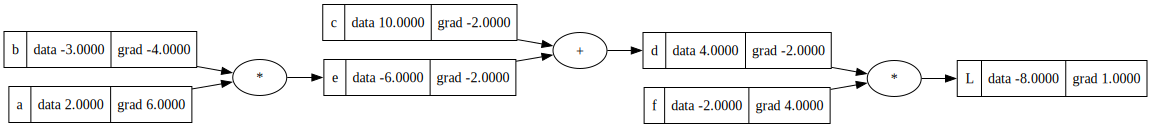

In [67]:
draw_dot(L)

In [66]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2
c.grad = -2
e.grad = -2
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label= "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label= "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

# Mannual Back propagation 

1.000000000000334


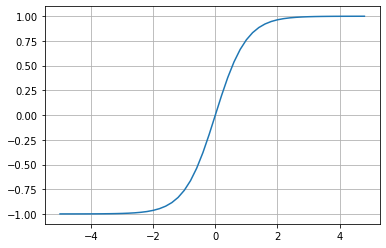

In [68]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

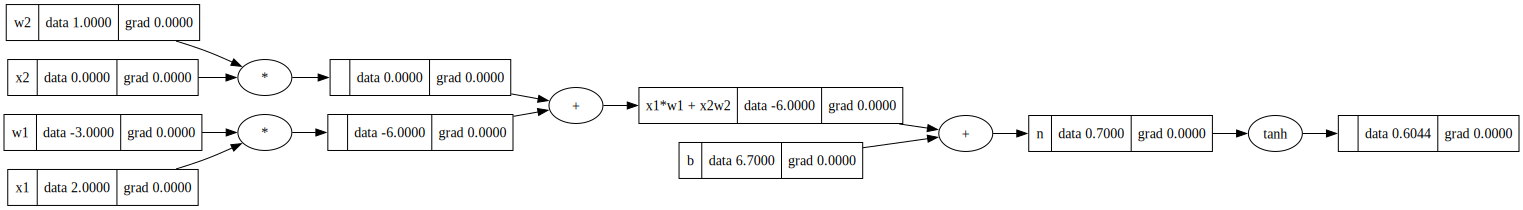

In [71]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1*w1 + x2*w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()
draw_dot(o)